In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
customers = pd.read_excel('/home/joao/code/capstone/data/Customers.xlsx')
orders = pd.read_excel('/home/joao/code/capstone/data/Orders.xlsx')

In [3]:
customers.head()

,Customer_ID,GENDER,AGE,GEOGRAPHY
0,2547,M,43,Greece
1,822,M,42,Spain
2,3686,F,39,France
3,3719,F,30,Italy
4,9200,F,31,Italy


In [4]:
orders.head()

,id,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,2021-01-02,2547,1,X52,0EM7L,1.0,3.13
1,2,2021-01-02,822,2,2ML,68BRQ,1.0,5.46
2,3,2021-01-02,3686,3,0H2,CZUZX,1.0,6.35
3,4,2021-01-02,3719,4,0H2,549KK,1.0,5.59
4,5,2021-01-02,9200,5,0H2,K8EHH,1.0,6.88


In [5]:
customers.dtypes

Customer_ID     int64
GENDER         object
AGE             int64
GEOGRAPHY      object
dtype: object

In [6]:
orders.dtypes

id                         int64
Date              datetime64[ns]
Customer_ID                int64
Transaction_ID             int64
SKU_Category              object
SKU                       object
Quantity                 float64
Sales_Amount             float64
dtype: object

### Cleaning the data

In [7]:
customers = customers.rename(columns={
    'Customer_ID':'customer_id',
    'GENDER':'gender',
    'AGE':'age',
    'GEOGRAPHY':'country'
})

In [8]:
customers.columns

Index(['customer_id', 'gender', 'age', 'country'], dtype='object')

In [9]:
orders = orders.rename(columns= {
    'Date':'date',
    'Customer_ID':'customer_id',
    'Transaction_ID':'transaction_id',
    'SKU_Category':'sku_category',
    'SKU':'sku',
    'Quantity':'quantity',
    'Sales_Amount':'sales_amount'
})

In [10]:
orders.columns

Index(['id', 'date', 'customer_id', 'transaction_id', 'sku_category', 'sku',
       'quantity', 'sales_amount'],
      dtype='object')

In [11]:
customers.isna().sum()

customer_id    0
gender         0
age            0
country        0
dtype: int64

In [12]:
orders.isna().sum()

id                0
date              0
customer_id       0
transaction_id    0
sku_category      0
sku               0
quantity          0
sales_amount      0
dtype: int64

In [13]:
# Merging the two DataFrames on 'customer_id'
merged_df = pd.merge(orders, customers, on='customer_id', how='inner')

# Display the first few rows of the merged DataFrame
merged_df.head()


,id,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,gender,age,country
0,1,2021-01-02,2547,1,X52,0EM7L,1.0,3.13,M,43,Greece
1,639,2021-01-04,2547,332,Q4N,MM3E0,1.0,12.69,M,43,Greece
2,7800,2021-01-25,2547,3743,X52,885U7,1.0,4.95,M,43,Greece
3,7801,2021-01-25,2547,3743,29A,A59HR,3.0,6.24,M,43,Greece
4,17633,2021-02-22,2547,8477,L9F,7W8WS,1.0,11.75,M,43,Greece


In [43]:
# merged_df.to_csv('merged_df.csv', index=False)

### EDA

In [17]:
from datetime import datetime

merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              131706 non-null  int64         
 1   date            131706 non-null  datetime64[ns]
 2   customer_id     131706 non-null  int64         
 3   transaction_id  131706 non-null  int64         
 4   sku_category    131706 non-null  object        
 5   sku             131706 non-null  object        
 6   quantity        131706 non-null  float64       
 7   sales_amount    131706 non-null  float64       
 8   gender          131706 non-null  object        
 9   age             131706 non-null  int64         
 10  country         131706 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 11.1+ MB


In [18]:
print("\nUnique values:")
print(merged_df.nunique().sort_values(ascending=False))


Unique values:
id                131706
transaction_id     64682
customer_id        22625
sku                 5242
sales_amount        3233
date                 362
sku_category         187
quantity              83
age                   45
country                7
gender                 2
dtype: int64


### Customer Segmentation

Recency (R): How recently a customer has made a purchase. We can calculate this by finding the number of days since a customer's last purchase.

Frequency (F): How often a customer makes a purchase. We can calculate this by counting the number of transactions each customer has made.

Monetary (M): How much money a customer has spent. We can calculate this by summing up the sales amount for each customer.


In [19]:
# Determine the most recent date in the dataset for recency calculation
most_recent_date = merged_df['date'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = merged_df.groupby('customer_id').agg({
    'date': lambda x: (most_recent_date - x.max()).days,  # Recency (days since last purchase)
    'transaction_id': 'nunique',  # Frequency (total number of transactions)
    'sales_amount': 'sum'  # Monetary (total amount of money spent)
}).rename(columns={'date': 'Recency', 'transaction_id': 'Frequency', 'sales_amount': 'Monetary'})

rfm.head()

,Recency,Frequency,Monetary
customer_id,,,
1,344,1,16.29
2,196,2,22.77
3,364,1,10.92
4,53,2,33.29
5,180,5,78.82


In [20]:
# Calculate quartiles for RFM metrics
quartiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quartiles = quartiles.to_dict()

# Functions to assign scores to Recency, Frequency, and Monetary
def r_score(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

def fm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Assigning scores
rfm['R_Score'] = rfm['Recency'].apply(r_score, args=('Recency', quartiles))
rfm['F_Score'] = rfm['Frequency'].apply(fm_score, args=('Frequency', quartiles))
rfm['M_Score'] = rfm['Monetary'].apply(fm_score, args=('Monetary', quartiles))

# Combining scores to create RFM Segment
rfm['RFM_Segment'] = rfm['R_Score'].map(str) + rfm['F_Score'].map(str) + rfm['M_Score'].map(str)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment
customer_id,,,,,,,
1,344,1,16.29,1,1,2,112
2,196,2,22.77,2,3,2,232
3,364,1,10.92,1,1,2,112
4,53,2,33.29,3,3,3,333
5,180,5,78.82,2,4,4,244


In [21]:
# Analyzing the size of each segment
segment_size = rfm['RFM_Segment'].value_counts().reset_index()
segment_size.columns = ['RFM_Segment', 'Size']

# Calculating average values for RFM metrics in each segment
segment_analysis = rfm.groupby('RFM_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).reset_index()

segment_analysis.columns = ['RFM_Segment', 'Average Recency', 'Average Frequency', 'Average Monetary', 'Count']

segment_size


,RFM_Segment,Size
0,444,2111
1,111,1697
2,211,1610
3,311,1265
4,112,1243
5,212,1060
6,312,936
7,333,763
8,411,698
9,344,694


In [22]:
segment_analysis.head(20)

,RFM_Segment,Average Recency,Average Frequency,Average Monetary,Count
0,111,319.199175,1.000000,5.901061,1697
1,112,318.701529,1.000000,15.342076,1243
2,113,320.597353,1.000000,37.241304,529
3,114,318.874372,1.000000,123.450603,199
4,131,309.750000,2.012500,7.745625,80
5,132,307.200993,2.178660,16.921241,403
6,133,307.561017,2.330508,39.388915,590
7,134,305.315341,2.463068,144.086818,352
8,142,307.000000,4.210526,20.672632,19
9,143,299.092857,4.578571,42.639500,140


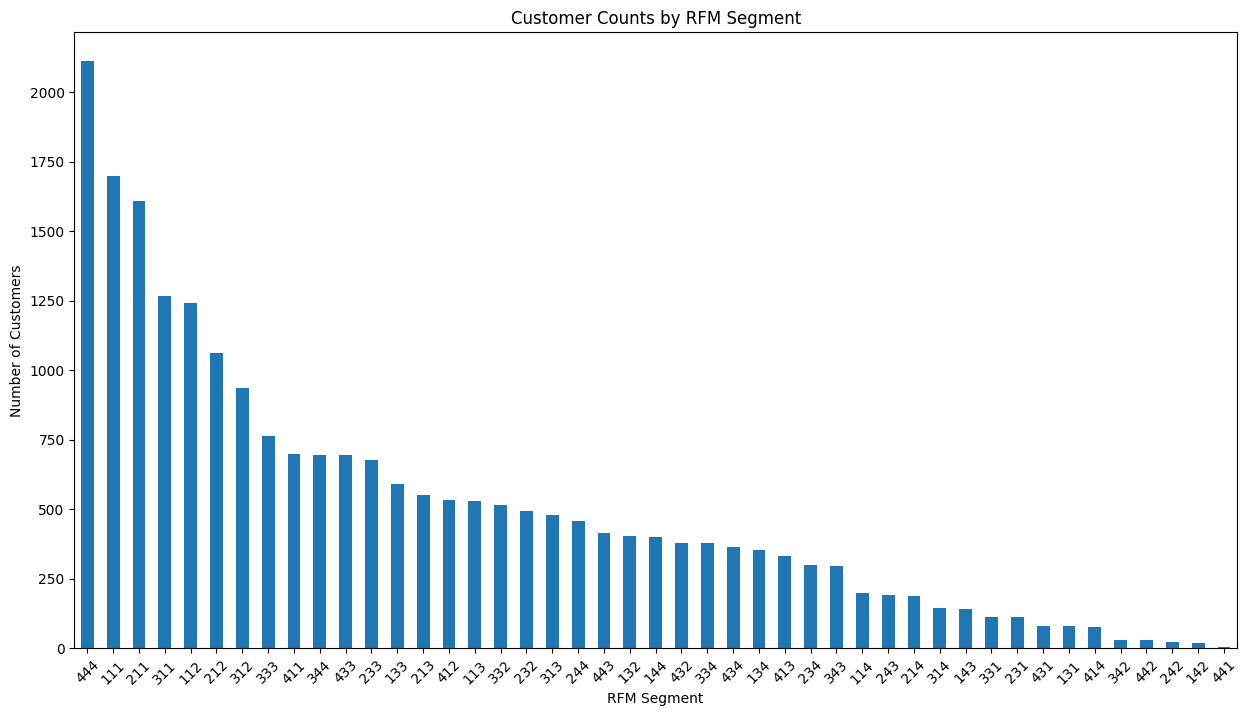

In [27]:
# Creating a bar chart for RFM segment counts
rfm_segment_counts = rfm['RFM_Segment'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(15, 8))
rfm_segment_counts.plot(kind='bar')
plt.title('Customer Counts by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

In [23]:
rfm.to_csv('rfm.csv', index=False)